# Get the data

In [1]:
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import macrosynergy.management as msm
import qstools.indicators as qsi

import warnings
warnings.simplefilter('ignore')

In [2]:
cids_dmca = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'NOK', 'NZD', 'SEK', 'USD']  # DM currency areas
cids_dmec = ['DEM', 'ESP', 'FRF', 'ITL', 'NLG']  # DM euro area countries
cids_latm = ['ARS', 'BRL', 'COP', 'CLP', 'MXN', 'PEN']  # Latam countries
cids_emea = ['HUF', 'ILS', 'PLN', 'RON', 'RUB', 'TRY', 'ZAR']  # EMEA countries
cids_emas = ['CNY', 'HKD', 'IDR', 'INR', 'KRW', 'MYR', 'PHP', 'SGD', 'THB', 'TWD']  # EM Asia countries
cids_dm = cids_dmca + cids_dmec
cids_em = cids_latm + cids_emea + cids_emas
cids = sorted(cids_dm + cids_em)

In [3]:
from_DB = False
path_to_feather = "..//..//data//feathers//"

xcats = ['BXBGDPRATIO_NSA_12MMA', 'BXBGDPRATIO_NSA_12MMA_D1M1ML3',
         'CABGDPRATIO_NSA_12MMA', 'MTBGDPRATIO_NSA_12MMA',
         'MTBGDPRATIO_NSA_12MMA_D1M1ML3', 'NFDIGDPRATIO_NSA_12MMA']

if from_DB:
    dbi = qsi.DownloadQuantamentalIndicators(username="rsueppel",
                                             host="qs-db.cpdsgdta9z0z.eu-west-2.rds.amazonaws.com",
                                             password="l3oT7^WerjY#O!9EGqvL",
                                             database="qs_jpm_point_time")
    dfd = dbi.get_xcat(cross_section = cids, xcat = xcats).reset_index(drop=True)
    dfd.to_feather(f'{path_to_feather}dfd_xbr_qmtl.ftr')   
else:
    dfd = pd.read_feather(f'{path_to_feather}dfd_xbr_qmtl.ftr')

In [4]:
dfd[['cid', 'xcat']] = dfd['ticker'].str.split('_', 1, expand=True)
dfd['real_date'] = pd.to_datetime(dfd['real_date'])

In [5]:
dfd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023249 entries, 0 to 1023248
Data columns (total 8 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   ticker     1023249 non-null  object        
 1   real_date  1023249 non-null  datetime64[ns]
 2   value      1023249 non-null  float64       
 3   grading    1023249 non-null  object        
 4   eop_lag    1023249 non-null  int64         
 5   mop_lag    1023249 non-null  int64         
 6   cid        1023249 non-null  object        
 7   xcat       1023249 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 62.5+ MB


# Check availability

In [7]:
cids_exp = sorted(list(set(cids) - set(cids_dmec + ['ARS', 'HKD'])))
msm.missing_in_df(dfd, xcats=xcats, cids=cids_exp)

Missing xcats across df:  set()
Missing cids for BXBGDPRATIO_NSA_12MMA:  set()
Missing cids for BXBGDPRATIO_NSA_12MMA_D1M1ML3:  set()
Missing cids for CABGDPRATIO_NSA_12MMA:  set()
Missing cids for MTBGDPRATIO_NSA_12MMA:  set()
Missing cids for MTBGDPRATIO_NSA_12MMA_D1M1ML3:  set()
Missing cids for NFDIGDPRATIO_NSA_12MMA:  set()


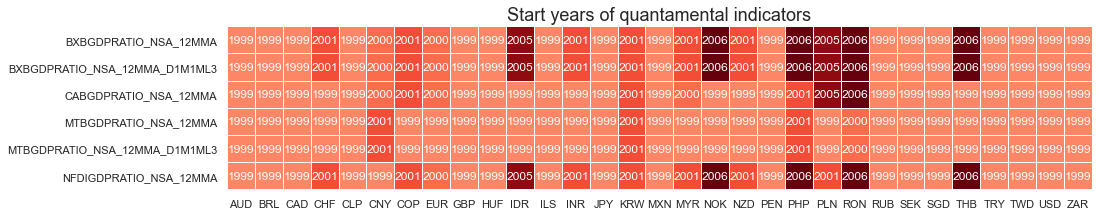

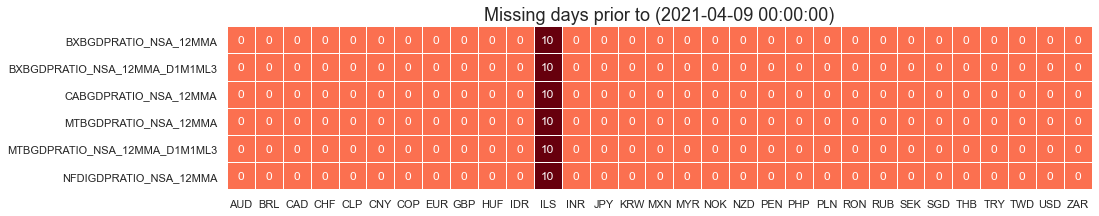

In [8]:
msm.check_availability(dfd, xcats=xcats, cids=cids_exp)

# Panel distributions and timelines